In [28]:
import os
import sys
import torch
import numpy as np

import datetime
import logging
import provider
import importlib
import shutil
import argparse
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
from data_utils.ModelNetDataLoader import ModelNetDataLoader

# 设置基本的目录变量
BASE_DIR = os.path.dirname(os.path.abspath('__file__')) # 基本目录
ROOT_DIR = BASE_DIR # 根目录
sys.path.append(os.path.join(ROOT_DIR, 'models')) # 模型目录

# 显示当前目录
print(f"当前工作目录：{BASE_DIR}")

当前工作目录：/home/cyj/deep_learning_notes/general_pointcloud/Pointnet&pointnet++


In [29]:
def log_string(str):
        logger.info(str)
        print(str)

In [30]:
def parse_args():
    '''PARAMETERS'''
    parser = argparse.ArgumentParser('training')
    parser.add_argument('--use_cpu', action='store_true', default=False, help='use cpu mode')
    parser.add_argument('--gpu', type=str, default='0', help='specify gpu device')
    parser.add_argument('--batch_size', type=int, default=24, help='batch size in training')
    parser.add_argument('--model', default='pointnet_cls', help='model name [default: pointnet_cls]')
    parser.add_argument('--num_category', default=40, type=int, choices=[10, 40],  help='training on ModelNet10/40')
    parser.add_argument('--epoch', default=200, type=int, help='number of epoch in training')
    parser.add_argument('--learning_rate', default=0.001, type=float, help='learning rate in training')
    parser.add_argument('--num_point', type=int, default=1024, help='Point Number')
    parser.add_argument('--optimizer', type=str, default='Adam', help='optimizer for training')
    parser.add_argument('--log_dir', type=str, default=None, help='experiment root')
    parser.add_argument('--decay_rate', type=float, default=1e-4, help='decay rate')
    parser.add_argument('--use_normals', action='store_true', default=False, help='use normals')
    parser.add_argument('--process_data', action='store_true', default=False, help='save data offline')
    parser.add_argument('--use_uniform_sample', action='store_true', default=False, help='use uniform sampiling')
    parser.add_argument('--continue_from_checkpoint', action='store_true', help='Continue training from checkpoint if available')
    parser.add_argument('--no_continue_from_checkpoint', action='store_false', dest='continue_from_checkpoint', help='Start training from scratch')
    parser.set_defaults(continue_from_checkpoint=True)
    return parser.parse_args()
    
sys.argv = ['train_classification.py','--model','pointnet2_cls_ssg','--log_dir','pointnet2_cls_ssg']
# 参数解析
args = parse_args()

In [31]:
'''HYPER PARAMETER'''
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu

'''CREATE DIR'''
timestr = str(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M'))
exp_dir = Path('./log/')
exp_dir.mkdir(exist_ok=True)
exp_dir = exp_dir.joinpath('classification')
exp_dir.mkdir(exist_ok=True)
if args.log_dir is None:
    exp_dir = exp_dir.joinpath(timestr)
else:
    exp_dir = exp_dir.joinpath(args.log_dir)
exp_dir.mkdir(exist_ok=True)
checkpoints_dir = exp_dir.joinpath('checkpoints/')
checkpoints_dir.mkdir(exist_ok=True)
log_dir = exp_dir.joinpath('logs/')
log_dir.mkdir(exist_ok=True)

In [32]:
# 定义一个inplace_relu函数。这个函数将被应用到模型的每个模块（或子模块）上。
# 如果模块是ReLU（Rectified Linear Unit）激活函数，这个函数会设置其为原地操作（in-place），这意味着直接修改输入而不是创建一个新的输出。
def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True

# 测试 inplace_relu 函数
print("测试 inplace_relu 函数...")

测试 inplace_relu 函数...


In [33]:


# 定义一个测试函数，用于评估模型在给定数据集上的性能。
# model: 要评估的模型
# loader: 数据加载器，包含测试数据
# num_class: 类别的数量，默认为40（ModelNet40数据集）
def test(model, loader, num_class=40):
    mean_correct = []  # 用于存储每个批次的平均正确率
    class_acc = np.zeros((num_class, 3))  # 用于存储每个类别的准确率
    classifier = model.eval()  # 将模型设置为评估模式

    # 对加载器中的每个批次进行迭代
    for j, (points, target) in tqdm(enumerate(loader), total=len(loader)):

        # 如果不使用CPU，则将数据移动到GPU
        if not args.use_cpu:
            points, target = points.cuda(), target.cuda()

        # 调整点云数据的维度
        points = points.transpose(2, 1)
        # 通过模型进行预测
        pred, _ = classifier(points)
        # 获取每个点云的预测类别
        pred_choice = pred.data.max(1)[1]

        # 输出预测和实际的类别，以便观察模型的表现
        print(f"Batch {j+1}:")
        print("Predicted classes:", pred_choice)
        print("Actual classes:", target)


        # 对每个独特类别的点云进行迭代
        for cat in np.unique(target.cpu()):
            # 计算每个类别的准确率
            classacc = pred_choice[target == cat].eq(target[target == cat].long().data).cpu().sum()
            class_acc[cat, 0] += classacc.item() / float(points[target == cat].size()[0])
            class_acc[cat, 1] += 1

        # 计算整个批次的正确率
        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))

    # 计算每个类别的平均准确率
    class_acc[:, 2] = class_acc[:, 0] / class_acc[:, 1]
    class_acc = np.mean(class_acc[:, 2])
    # 计算所有批次的平均正确率
    instance_acc = np.mean(mean_correct)

    # 在函数结束时输出最终的分类准确率
    print(f"Instance Accuracy: {instance_acc}")
    print(f"Class Accuracy: {class_acc}")
    
    return instance_acc, class_acc


In [34]:
# 创建日志记录器
logger = logging.getLogger("Model")
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler = logging.FileHandler('%s/%s.txt' % (log_dir, args.model))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)
log_string('参数设置：')
log_string(args)


参数设置：
Namespace(batch_size=24, continue_from_checkpoint=True, decay_rate=0.0001, epoch=200, gpu='0', learning_rate=0.001, log_dir='pointnet2_cls_ssg', model='pointnet2_cls_ssg', num_category=40, num_point=1024, optimizer='Adam', process_data=False, use_cpu=False, use_normals=False, use_uniform_sample=False)


In [35]:
test_instance_acc_history = []
test_class_acc_history = []
# 加载数据集
log_string('Load dataset ...')
data_path = 'data/modelnet40_normal_resampled/'

train_dataset = ModelNetDataLoader(root=data_path, args=args, split='train', process_data=args.process_data)
test_dataset = ModelNetDataLoader(root=data_path, args=args, split='test', process_data=args.process_data)
trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=10, drop_last=True)
testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=10)

# 输出数据集信息
print("训练集大小：", len(train_dataset))
print("测试集大小：", len(test_dataset))


Load dataset ...
The size of train data is 9843
The size of test data is 2468
训练集大小： 9843
测试集大小： 2468


In [36]:

# 模型初始化
log_string('正在初始化模型...')
'''MODEL LOADING'''
num_class = args.num_category
model = importlib.import_module(args.model)
shutil.copy('./models/%s.py' % args.model, str(exp_dir))
shutil.copy('models/pointnet2_utils.py', str(exp_dir))
shutil.copy('./train_classification.py', str(exp_dir))

classifier = model.get_model(num_class, normal_channel=args.use_normals)
criterion = model.get_loss()
classifier.apply(inplace_relu)

if not args.use_cpu:
    classifier = classifier.cuda()
    criterion = criterion.cuda()

if args.continue_from_checkpoint:
    try:
        checkpoint = torch.load(str(exp_dir) + '/checkpoints/best_model.pth')
        start_epoch = checkpoint['epoch']
        classifier.load_state_dict(checkpoint['model_state_dict'])
        log_string('Use pretrain model')
    except:
        log_string('No existing model, starting training from scratch...')
        start_epoch = 0
else:
    log_string('Starting training from scratch...')
    start_epoch = 0


if args.optimizer == 'Adam':
    optimizer = torch.optim.Adam(
        classifier.parameters(),
        lr=args.learning_rate,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=args.decay_rate
    )
else:
    optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)


正在初始化模型...
No existing model, starting training from scratch...


In [37]:
# 训练模型
logger.info('开始训练...')
for epoch in range(start_epoch, args.epoch):
        #训练过程
        log_string('Epoch %d (%d/%s):' % (global_epoch + 1, epoch + 1, args.epoch))
        mean_correct = []
        classifier = classifier.train()

        scheduler.step()
        for batch_id, (points, target) in tqdm(enumerate(trainDataLoader, 0), total=len(trainDataLoader), smoothing=0.9):
            optimizer.zero_grad()

            points = points.data.numpy()
            points = provider.random_point_dropout(points)
            points[:, :, 0:3] = provider.random_scale_point_cloud(points[:, :, 0:3])
            points[:, :, 0:3] = provider.shift_point_cloud(points[:, :, 0:3])
            points = torch.Tensor(points)
            points = points.transpose(2, 1)

            if not args.use_cpu:
                points, target = points.cuda(), target.cuda()

            pred, trans_feat = classifier(points)
            loss = criterion(pred, target.long(), trans_feat)
            pred_choice = pred.data.max(1)[1]

            correct = pred_choice.eq(target.long().data).cpu().sum()
            mean_correct.append(correct.item() / float(points.size()[0]))
            loss.backward()
            optimizer.step()
            global_step += 1
            print(f"批次 {batch_id+1}/{len(trainDataLoader)}，损失：{loss.item()}")

        train_instance_acc = np.mean(mean_correct)
        log_string('Train Instance Accuracy: %f' % train_instance_acc)
        # 输出训练轮次的结果
        print(f"训练完成，第 {epoch+1}/{args.epoch} 轮，准确率：{train_instance_acc}")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cyj/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2114834/3867190247.py", line 5, in <module>
    log_string('Epoch %d (%d/%s):' % (global_epoch + 1, epoch + 1, args.epoch))
NameError: name 'global_epoch' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cyj/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/cyj/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1396, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/cyj/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1287, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/home/cyj/.

In [38]:
#测试过程
with torch.no_grad():
    instance_acc, class_acc = test(classifier.eval(), testDataLoader, num_class=num_class)

    # 将测试精度添加到列表中
    test_instance_acc_history.append(instance_acc)
    test_class_acc_history.append(class_acc)

    # 输出测试结果
    log_string('测试实例准确率: %f, 类别准确率: %f' % (instance_acc, class_acc))
    log_string('最佳实例准确率: %f, 类别准确率: %f' % (best_instance_acc, best_class_acc))

    # 保存最佳模型
    if (instance_acc >= best_instance_acc):
        # 保存操作
        log_string('保存模型中...')
        best_instance_acc = instance_acc
        best_epoch = epoch + 1

    if (class_acc >= best_class_acc):
        best_class_acc = class_acc
    log_string('Test Instance Accuracy: %f, Class Accuracy: %f' % (instance_acc, class_acc))
    log_string('Best Instance Accuracy: %f, Class Accuracy: %f' % (best_instance_acc, best_class_acc))

    if (instance_acc >= best_instance_acc):
        logger.info('Save model...')
        savepath = str(checkpoints_dir) + '/best_model.pth'
        log_string('Saving at %s' % savepath)
        state = {
            'epoch': best_epoch,
            'instance_acc': instance_acc,
            'class_acc': class_acc,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(state, savepath)
    global_epoch += 1


  2%|▏         | 2/103 [00:00<00:32,  3.09it/s]

Batch 1:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.int32)
Batch 2:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.int32)


  4%|▍         | 4/103 [00:00<00:17,  5.63it/s]

Batch 3:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.int32)
Batch 4:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.int32)


  6%|▌         | 6/103 [00:01<00:13,  7.40it/s]

Batch 5:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0', dtype=torch.int32)
Batch 6:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0', dtype=torch.int32)


  9%|▊         | 9/103 [00:01<00:10,  8.88it/s]

Batch 7:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0', dtype=torch.int32)
Batch 8:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0', dtype=torch.int32)
Batch 9:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0', dtype=torch.int32)


 12%|█▏        | 12/103 [00:01<00:09,  9.55it/s]

Batch 10:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:0', dtype=torch.int32)
Batch 11:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       device='cuda:0', dtype=torch.int32)
Batch 12:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0', dtype=torch.int32)


 14%|█▎        | 14/103 [00:01<00:09,  9.70it/s]

Batch 13:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0', dtype=torch.int32)
Batch 14:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0', dtype=torch.int32)


 17%|█▋        | 17/103 [00:02<00:08,  9.89it/s]

Batch 15:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
       device='cuda:0', dtype=torch.int32)
Batch 16:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0', dtype=torch.int32)
Batch 17:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0', dtype=torch.int32)


 18%|█▊        | 19/103 [00:02<00:08,  9.97it/s]

Batch 18:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0', dtype=torch.int32)
Batch 19:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0', dtype=torch.int32)
Batch 20:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:0', dtype=torch.int32)


 21%|██▏       | 22/103 [00:02<00:08,  9.89it/s]

Batch 21:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       device='cuda:0', dtype=torch.int32)
Batch 22:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       device='cuda:0', dtype=torch.int32)


 23%|██▎       | 24/103 [00:02<00:07,  9.89it/s]

Batch 23:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       device='cuda:0', dtype=torch.int32)
Batch 24:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
       device='cuda:0', dtype=torch.int32)


 25%|██▌       | 26/103 [00:03<00:07,  9.91it/s]

Batch 25:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       device='cuda:0', dtype=torch.int32)
Batch 26:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       device='cuda:0', dtype=torch.int32)


 27%|██▋       | 28/103 [00:03<00:07,  9.83it/s]

Batch 27:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       device='cuda:0', dtype=torch.int32)
Batch 28:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       device='cuda:0', dtype=torch.int32)


 29%|██▉       | 30/103 [00:03<00:07,  9.77it/s]

Batch 29:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9],
       device='cuda:0', dtype=torch.int32)
Batch 30:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10], device='cuda:0', dtype=torch.int32)


 31%|███       | 32/103 [00:03<00:07,  9.79it/s]

Batch 31:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11], device='cuda:0', dtype=torch.int32)
Batch 32:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12], device='cuda:0', dtype=torch.int32)


 33%|███▎      | 34/103 [00:03<00:07,  9.85it/s]

Batch 33:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12], device='cuda:0', dtype=torch.int32)
Batch 34:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12], device='cuda:0', dtype=torch.int32)


 35%|███▍      | 36/103 [00:04<00:06,  9.88it/s]

Batch 35:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 13, 13, 13, 13], device='cuda:0', dtype=torch.int32)
Batch 36:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14,
        14, 14, 14, 14, 14, 14], device='cuda:0', dtype=torch.int32)


 37%|███▋      | 38/103 [00:04<00:06,  9.91it/s]

Batch 37:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14], device='cuda:0', dtype=torch.int32)
Batch 38:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14], device='cuda:0', dtype=torch.int32)
Batch 39:
Predicted classes: 

 39%|███▉      | 40/103 [00:04<00:06,  9.91it/s]

tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14], device='cuda:0', dtype=torch.int32)
Batch 40:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        15, 15, 15, 15, 15, 15], device='cuda:0', dtype=torch.int32)


 41%|████      | 42/103 [00:04<00:06,  9.91it/s]

Batch 41:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16], device='cuda:0', dtype=torch.int32)
Batch 42:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16], device='cuda:0', dtype=torch.int32)


 42%|████▏     | 43/103 [00:04<00:06,  9.87it/s]

Batch 43:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16], device='cuda:0', dtype=torch.int32)
Batch 44:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16], device='cuda:0', dtype=torch.int32)


 45%|████▍     | 46/103 [00:05<00:05,  9.88it/s]

Batch 45:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17], device='cuda:0', dtype=torch.int32)
Batch 46:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17], device='cuda:0', dtype=torch.int32)
Batch 47:
Predicted classes: 

 47%|████▋     | 48/103 [00:05<00:05,  9.96it/s]

tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17], device='cuda:0', dtype=torch.int32)
Batch 48:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17], device='cuda:0', dtype=torch.int32)
Batch 49:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18], device='cuda:0', dtype=torch.int32)


 49%|████▊     | 50/103 [00:05<00:05,  9.97it/s]

Batch 50:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19], device='cuda:0', dtype=torch.int32)
Batch 51:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 21, 21], device='cuda:0', dtype=torch.int32)
Batch 52:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21], device='cuda:0', dtype=torch.int32)


 52%|█████▏    | 54/103 [00:05<00:04,  9.96it/s]

Batch 53:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21], device='cuda:0', dtype=torch.int32)
Batch 54:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21], device='cuda:0', dtype=torch.int32)
Batch 55:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
        21, 21, 21, 21, 21, 21], device='cuda:0', dtype=torch.int32)


 55%|█████▌    | 57/103 [00:06<00:04,  9.94it/s]

Batch 56:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22], device='cuda:0', dtype=torch.int32)
Batch 57:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22], device='cuda:0', dtype=torch.int32)


 58%|█████▊    | 60/103 [00:06<00:04,  9.94it/s]

Batch 58:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22], device='cuda:0', dtype=torch.int32)
Batch 59:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 22, 22, 22], device='cuda:0', dtype=torch.int32)
Batch 60:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23], device='cuda:0', dtype=torch.int32)


 60%|██████    | 62/103 [00:06<00:04,  9.94it/s]

Batch 61:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23], device='cuda:0', dtype=torch.int32)
Batch 62:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23], device='cuda:0', dtype=torch.int32)


 63%|██████▎   | 65/103 [00:07<00:03,  9.97it/s]

Batch 63:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 24, 24, 24, 24], device='cuda:0', dtype=torch.int32)
Batch 64:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25,
        25, 25, 25, 25, 25, 25], device='cuda:0', dtype=torch.int32)
Batch 65:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25], device='cuda:0', dtype=torch.int32)


 65%|██████▌   | 67/103 [00:07<00:03, 10.01it/s]

Batch 66:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25], device='cuda:0', dtype=torch.int32)
Batch 67:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 25, 25, 25, 25], device='cuda:0', dtype=torch.int32)
Batch 68:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
        25, 25, 26, 26, 26, 26], device='cuda:0', dtype=torch.int32)


 69%|██████▉   | 71/103 [00:07<00:03, 10.06it/s]

Batch 69:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26], device='cuda:0', dtype=torch.int32)
Batch 70:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26], device='cuda:0', dtype=torch.int32)
Batch 71:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26], device='cuda:0', dtype=torch.int32)


 71%|███████   | 73/103 [00:07<00:02, 10.08it/s]

Batch 72:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26], device='cuda:0', dtype=torch.int32)
Batch 73:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 28, 28, 28, 28], device='cuda:0', dtype=torch.int32)
Batch 74:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28], device='cuda:0', dtype=torch.int32)


 75%|███████▍  | 77/103 [00:08<00:02, 10.05it/s]

Batch 75:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28], device='cuda:0', dtype=torch.int32)
Batch 76:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28], device='cuda:0', dtype=torch.int32)
Batch 77:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28], device='cuda:0', dtype=torch.int32)


 77%|███████▋  | 79/103 [00:08<00:02, 10.01it/s]

Batch 78:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 30, 30, 30, 30], device='cuda:0', dtype=torch.int32)
Batch 79:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30], device='cuda:0', dtype=torch.int32)
Batch 80:
Predicted classes: 

 79%|███████▊  | 81/103 [00:08<00:02, 10.02it/s]

tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30], device='cuda:0', dtype=torch.int32)
Batch 81:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30], device='cuda:0', dtype=torch.int32)
Batch 82:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30], device='cuda:0', dtype=torch.int32)


 81%|████████  | 83/103 [00:08<00:01, 10.04it/s]

Batch 83:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
        31, 31, 32, 32, 32, 32], device='cuda:0', dtype=torch.int32)
Batch 84:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33,
        33, 33, 33, 33, 33, 33], device='cuda:0', dtype=torch.int32)


 84%|████████▍ | 87/103 [00:09<00:01, 10.06it/s]

Batch 85:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33], device='cuda:0', dtype=torch.int32)
Batch 86:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33], device='cuda:0', dtype=torch.int32)
Batch 87:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33], device='cuda:0', dtype=torch.int32)


 86%|████████▋ | 89/103 [00:09<00:01, 10.05it/s]

Batch 88:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 34, 34, 34, 34], device='cuda:0', dtype=torch.int32)
Batch 89:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35,
        35, 35, 35, 35, 35, 35], device='cuda:0', dtype=torch.int32)
Batch 90:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35], device='cuda:0', dtype=torch.int32)


 88%|████████▊ | 91/103 [00:09<00:01, 10.06it/s]

Batch 91:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35], device='cuda:0', dtype=torch.int32)
Batch 92:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35], device='cuda:0', dtype=torch.int32)
Batch 93:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 36, 36, 36, 36], device='cuda:0', dtype=torch.int32)


 92%|█████████▏| 95/103 [00:10<00:00,  9.95it/s]

Batch 94:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36], device='cuda:0', dtype=torch.int32)
Batch 95:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36], device='cuda:0', dtype=torch.int32)


 94%|█████████▍| 97/103 [00:10<00:00,  9.95it/s]

Batch 96:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36], device='cuda:0', dtype=torch.int32)
Batch 97:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
        36, 36, 36, 36, 36, 36], device='cuda:0', dtype=torch.int32)


 96%|█████████▌| 99/103 [00:10<00:00,  9.88it/s]

Batch 98:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0', dtype=torch.int32)
Batch 99:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0', dtype=torch.int32)


 98%|█████████▊| 101/103 [00:10<00:00,  9.82it/s]

Batch 100:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0', dtype=torch.int32)
Batch 101:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0', dtype=torch.int32)


100%|██████████| 103/103 [00:10<00:00,  9.43it/s]

Batch 102:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37, 37, 37, 37, 37], device='cuda:0')
Actual classes: tensor([37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
        38, 38, 38, 38, 38, 38], device='cuda:0', dtype=torch.int32)
Batch 103:
Predicted classes: tensor([37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        37, 37], device='cuda:0')
Actual classes: tensor([39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
        39, 39], device='cuda:0', dtype=torch.int32)
Instance Accuracy: 0.04045307443365696
Class Accuracy: 0.025
测试实例准确率: 0.040453, 类别准确率: 0.025000
Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/home/cyj/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2114834/2682510773.py", line 11, in <module>
    log_string('最佳实例准确率: %f, 类别准确率: %f' % (best_instance_acc, best_class_acc))
NameError: name 'best_instance_acc' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cyj/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/cyj/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1396, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/cyj/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1287, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/home

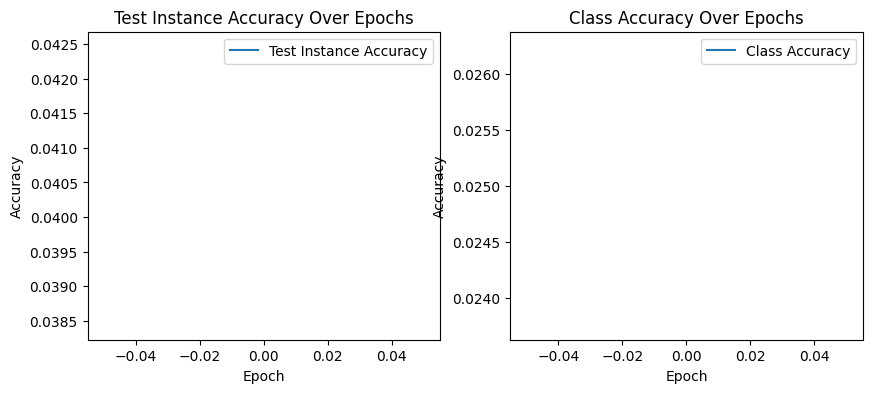

In [39]:
# 检查是否有图形界面环境（例如：使用DISPLAY环境变量）
if os.environ.get('DISPLAY', None):
    # 绘图
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(test_instance_acc_history, label='Test Instance Accuracy')
    plt.title('Test Instance Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_class_acc_history, label='Class Accuracy')
    plt.title('Class Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
else:
    # 没有图形界面环境，将图表保存为文件
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(test_instance_acc_history, label='Test Instance Accuracy')
    plt.title('Test Instance Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_class_acc_history, label='Class Accuracy')
    plt.title('Class Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    plt.savefig('accuracy_plot.png')

